In [1]:
import polars as pl
import json
from pathlib import Path
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import helper
import os
%matplotlib ipympl 

### Plot the data

In [14]:
chart_source = pl.read_parquet('./data/chart_source.parquet')

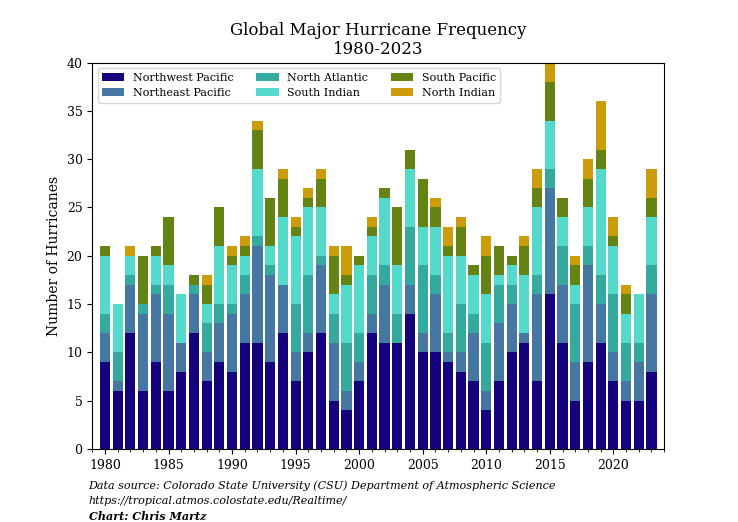

In [15]:
helper.make_chart(chart_source)

### Helper functions

In [3]:
def process_one_basin(basin):
    file_path = f'data/{basin}.json'

    with open(file_path, 'r') as file:
        # Read in json data (one file for each basin)
        data = json.load(file)
         
        # Convert json data to a list of dicts (to facilitate to conversion to a dataframe)
        records = [
            {
                'season': season,
                'named_storms': values[0],
                'named_storm_days': values[1],
                'hurricanes': values[2],
                'hurricane_days': values[3],
                'major_hurricanes': values[4],
                'major_hurricane_days': values[5],
                'ace': values[6],
            }
            for season, values in data.items()
        ]

        # Make a dataframe from the list-o-dicts
        df = (
            pl.DataFrame(records)
            .with_columns(
                pl.lit(basin).alias('basin'),
                pl.col('season').cast(pl.UInt16),
            )
        )

        # Put 'basin' column first and scoot the rest to the right
        cols = df.columns
        cols = cols[-1:] + cols[:-1]

    return df[cols]

In [4]:
def combine_input_sources():
    # Grab data from source .json files
    data_dir = Path('data')
    json_files = [file for file in data_dir.glob('*.json') if file.is_file()]

    # Combine all basin's pertinent data into one dataframe
    master_df = pl.DataFrame()

    for file in json_files:
        basin = file.stem
        master_df = master_df.vstack(process_one_basin(basin))

    return master_df

In [5]:
def extract_chart_data(master_df):
    allowable_basins = ['northwestpacific', 'northeastpacific', 'northatlantic', 'southindian', 'southpacific', 'northindian']

    # Grab only the data needed for the chart
    chart_df = (
        master_df
        .filter(
            pl.col('season').is_between(1980, 2023),
            pl.col('basin').is_in(allowable_basins)
        )
        .select(['basin', 'season', 'major_hurricanes'])
    )

    # Convert the long table to wide
    wide = chart_df.pivot(on='season', values='major_hurricanes')

    # Write df to file if necessary
    file_path = 'data/chart_source.parquet'
    if os.path.exists(file_path):
        print('No action necessary.')
    else:
        wide.write_parquet(file_path)
        print('Wrote chart_source.parquet.')

    return wide 

### Write combined data file if needed

In [13]:
extract_chart_data(combine_input_sources())

Wrote chart_source.parquet.


basin,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""northeastpacific""",3,1,5,8,7,8,3,4,3,4,6,5,10,9,5,3,2,7,6,2,2,2,6,0,3,2,6,1,2,5,2,6,5,1,9,11,6,4,10,4,3,2,4,8
"""southindian""",6,5,2,0,3,2,5,0,2,6,4,2,7,2,7,7,7,5,2,6,7,4,7,5,6,4,5,8,5,4,5,1,2,6,7,5,3,2,4,11,5,3,5,5
"""northatlantic""",2,3,1,1,1,3,0,1,3,2,1,2,1,1,0,5,6,1,3,5,3,4,2,3,6,7,2,2,5,2,5,4,2,0,2,2,4,6,2,3,6,4,2,3
"""southpacific""",1,0,0,5,1,5,0,1,2,4,1,1,4,5,4,1,1,3,4,1,1,1,1,6,2,5,2,1,3,1,4,3,1,3,2,4,2,2,3,2,1,2,0,2
"""northindian""",0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,1,1,1,3,0,1,0,0,0,0,1,2,1,0,2,0,0,1,2,2,0,1,2,5,2,1,0,3
"""northwestpacific""",9,6,12,6,9,6,8,12,7,9,8,11,11,9,12,7,10,12,5,4,7,12,11,11,14,10,10,9,8,7,4,7,10,11,7,16,11,5,9,11,7,5,5,8


### Concerns

#### Concern: totals do not match
There are too many "close but not quite" values.

Could be due to source data files changing.  (Data from the web site is just a snapshot.)

#### Concern: consistent stack order
Chris' stack order is not consistent year after year.

When it exists, North Indian should be the top-most stack piece.

Yet 1990, 1992, 2006, 2013, and 2014 all show North Indian be the second top-most stack piece.


#### Concern: multiple stack pieces in the same year

eg, 1990 has two South Indian stack pieces.  So does 1992.

This raises concern about the aggregation of data.


### Did CSU's online data change?
Chris' chart is missing a bunch of (mainly) South Indian hurricanes.  One hypothesis is that the source data changed since he did his chart.

That hypothesis is dismissed when comparing the data found in the Internet Archive as we see below...

In [6]:
master_df = combine_input_sources()

In [7]:
oct = master_df.filter(pl.col('basin') == 'southindian').select(['basin', 'season', 'major_hurricanes'])
jul = master_df.filter(pl.col('basin') == 'southindian-20240711').select(['basin', 'season', 'major_hurricanes']).with_columns(pl.lit('southindian').alias('basin'))
dec = master_df.filter(pl.col('basin') == 'southindian-20231210').select(['basin', 'season', 'major_hurricanes']).with_columns(pl.lit('southindian').alias('basin'))

In [8]:
diffs = (
    oct
    .join(dec, on=['basin', 'season'], how='left')
    .fill_null(0)
    .with_columns(
        (pl.col('major_hurricanes') - pl.col('major_hurricanes_right')).alias('diff')
    )
)

In [9]:
diffs

basin,season,major_hurricanes,major_hurricanes_right,diff
str,u16,i64,i64,i64
"""southindian""",1980,6,6,0
"""southindian""",1981,5,5,0
"""southindian""",1982,2,2,0
"""southindian""",1983,0,0,0
"""southindian""",1984,3,3,0
…,…,…,…,…
"""southindian""",2020,5,5,0
"""southindian""",2021,3,3,0
"""southindian""",2022,5,0,5


In [10]:
diffs.max()

basin,season,major_hurricanes,major_hurricanes_right,diff
str,u16,i64,i64,i64
"""southindian""",2024,11,11,5


In [12]:
diffs_scale = alt.Scale(
    domain=[-10, 0, 10],
    range=['red', 'transparent', 'green'],
)

heatmap = alt.Chart(diffs).encode(
    x='season:O',
    y='basin:N',
    color=alt.Color('diff:Q', scale=diffs_scale),
    tooltip=['season', 'basin', 'diff'],
).mark_rect()

text = heatmap.mark_text().encode(
    text=alt.condition(
        alt.datum.value != 0,
        'diff:Q',
        alt.value('x') 
    )
)

chart = alt.layer(heatmap, text).properties(
    title='Differences in South Indian source data (October - previous)'
)

chart.display()

alt.LayerChart(...)

Strange that the 3 most recent years don't appear in the .json file from Internet Archive but the table data is populated in the html for those years.